# Week 3 
## Data Normalization, Unsupervised Learning, Confusion matrix

## Learning Objectives

By the end of this week, you should be able to:

1. Apply **z-score normalization** and understand why it is necessary before PCA and clustering
2. Perform **PCA** for dimensionality reduction and interpret loadings, scores, and cumulative explained variance
3. Apply **K-Means** clustering and select K using the **elbow method** and **silhouette scores**
4. Apply **hierarchical clustering**, read a **dendrogram**, and compare different linkage methods
5. Evaluate unsupervised results against known labels using a **confusion matrix**

In [169]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('./heart_failure_clinical_records_dataset.csv') #make sure to replace with your data directory
#df.drop(columns=['time'],inplace=True) #drop the time column which is not one of the informative features 
df_features = df.iloc[:,:-1]
df_target = df['DEATH_EVENT']

In [170]:
df_features

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280


In [171]:
df_target

0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: DEATH_EVENT, Length: 299, dtype: int64

In [172]:
df_target.value_counts()

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

In [173]:
df_target.value_counts(normalize=True)

DEATH_EVENT
0    0.67893
1    0.32107
Name: proportion, dtype: float64

In [174]:
df_features.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')

# Data Normalization 

$$z = \frac{x - \mu}{\sigma}$$

z: zscore

$\mu$: average value 

$\sigma$: standard deviation 

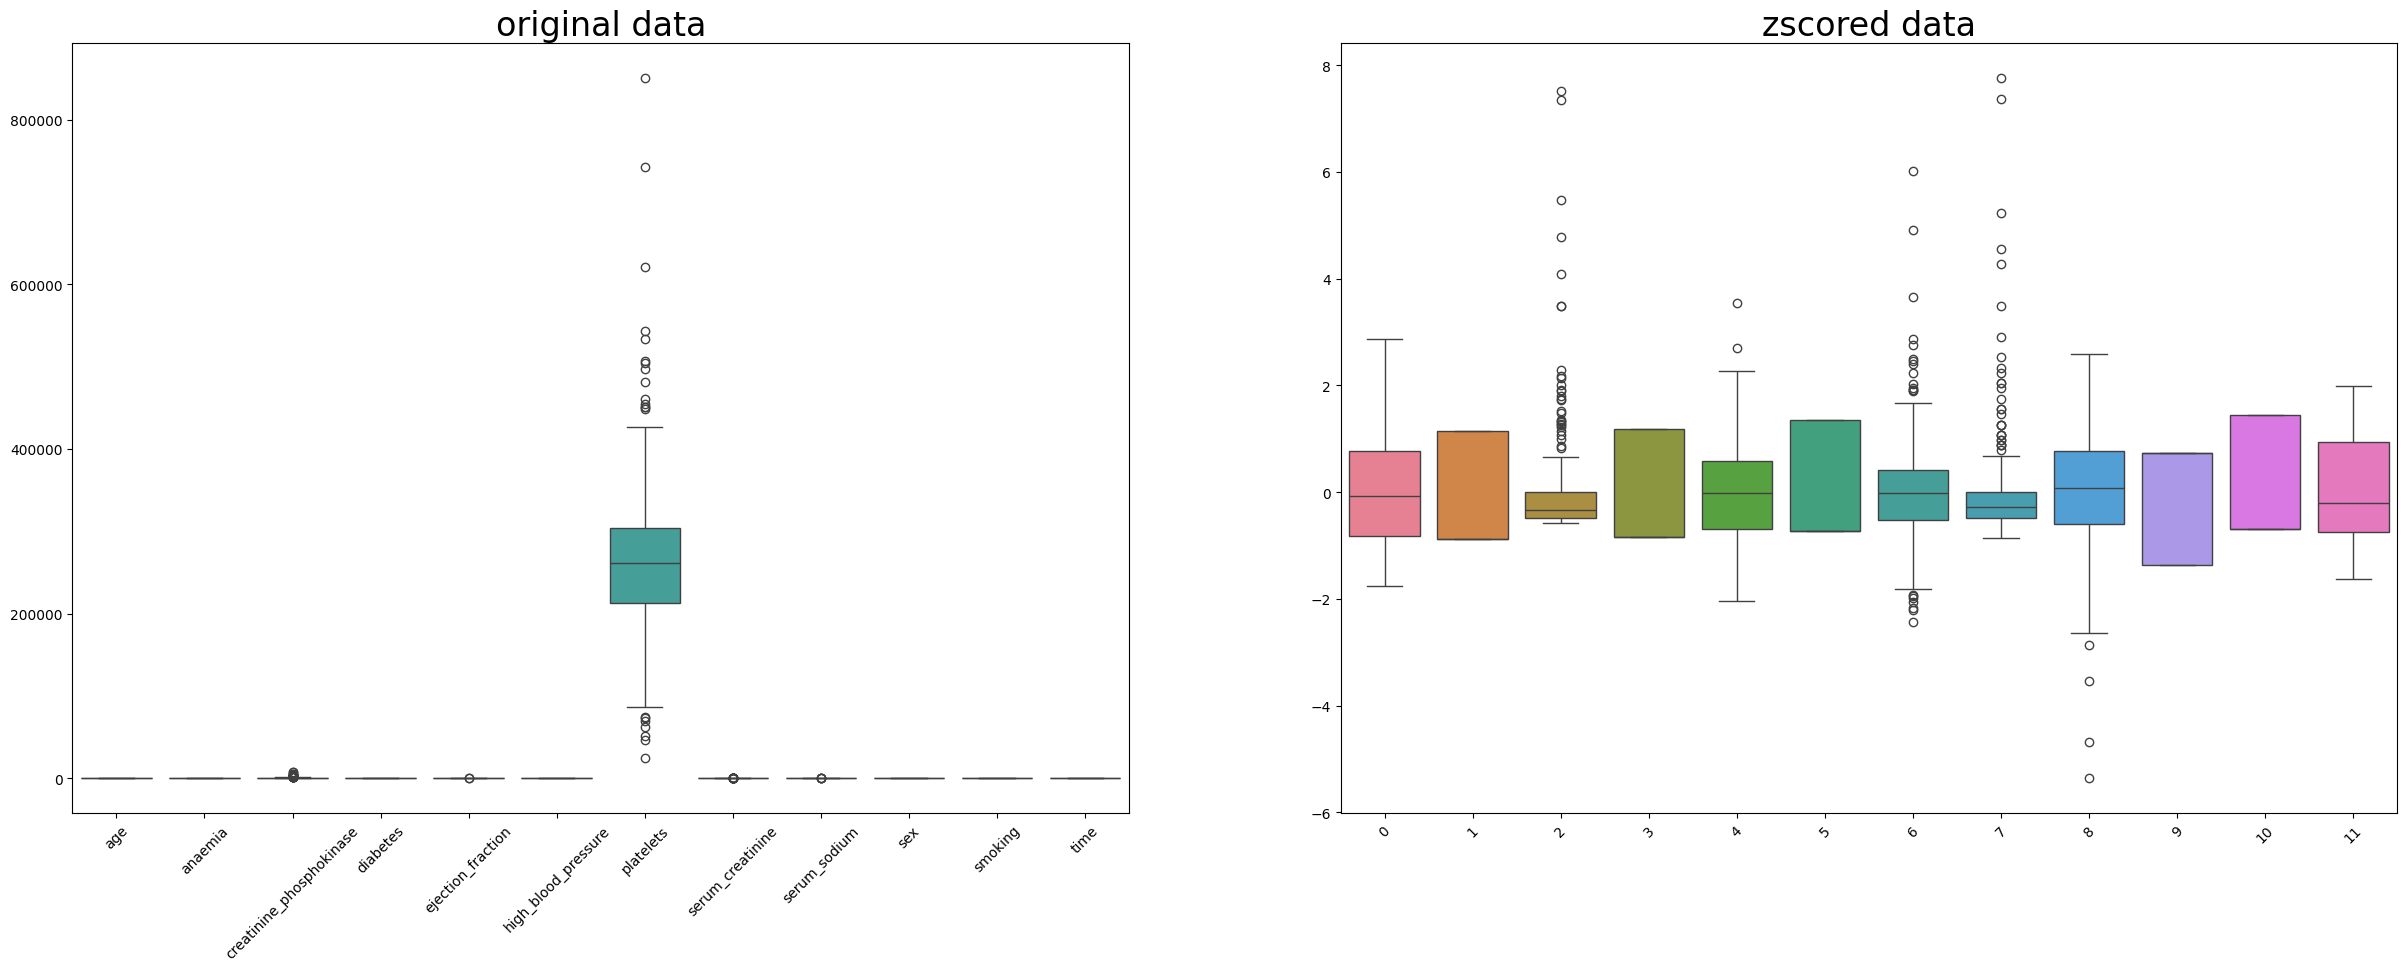

In [175]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

df_features_zscored = stats.zscore(df_features)
#plot both data including original and normalized
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.boxplot(df_features)
plt.title('original data',size=24)
plt.xticks(rotation=45);  # Rotate x-ticks by 45 degrees

plt.subplot(1,2,2)
sns.boxplot(df_features_zscored)
plt.title('zscored data', size = 24);
plt.xticks(rotation=45);  # Rotate x-ticks by 45 degrees


#plt.savefig('/Users/bonakdar/Desktop/org_zscore.png')

# Principal Component Analysis (PCA)

$X \sim Z.W^T$

X: original data

$Z.W^T$: reconstructed data

Goal: find a W (projection matrix) that minimizes the error between X and $Z.W^T$

In [176]:
from sklearn.decomposition import PCA
#PCA
pca = PCA(n_components=3)
pca = pca.fit(df_features_zscored)
y= pca.fit_transform(df_features_zscored)
loadings = pca.components_.T

In [177]:
pca.explained_variance_

array([1.66854625, 1.5843945 , 1.27239806])

In [178]:
pca.explained_variance_ratio_

array([0.13858049, 0.13159129, 0.10567855])

In [179]:
pca.components_.shape

(3, 12)

In [180]:
pca.n_components_

3

In [181]:
y.shape

(299, 3)

# loadings value: how strongly each feature contributes to each principal component

In [182]:
loadings.shape

(12, 3)

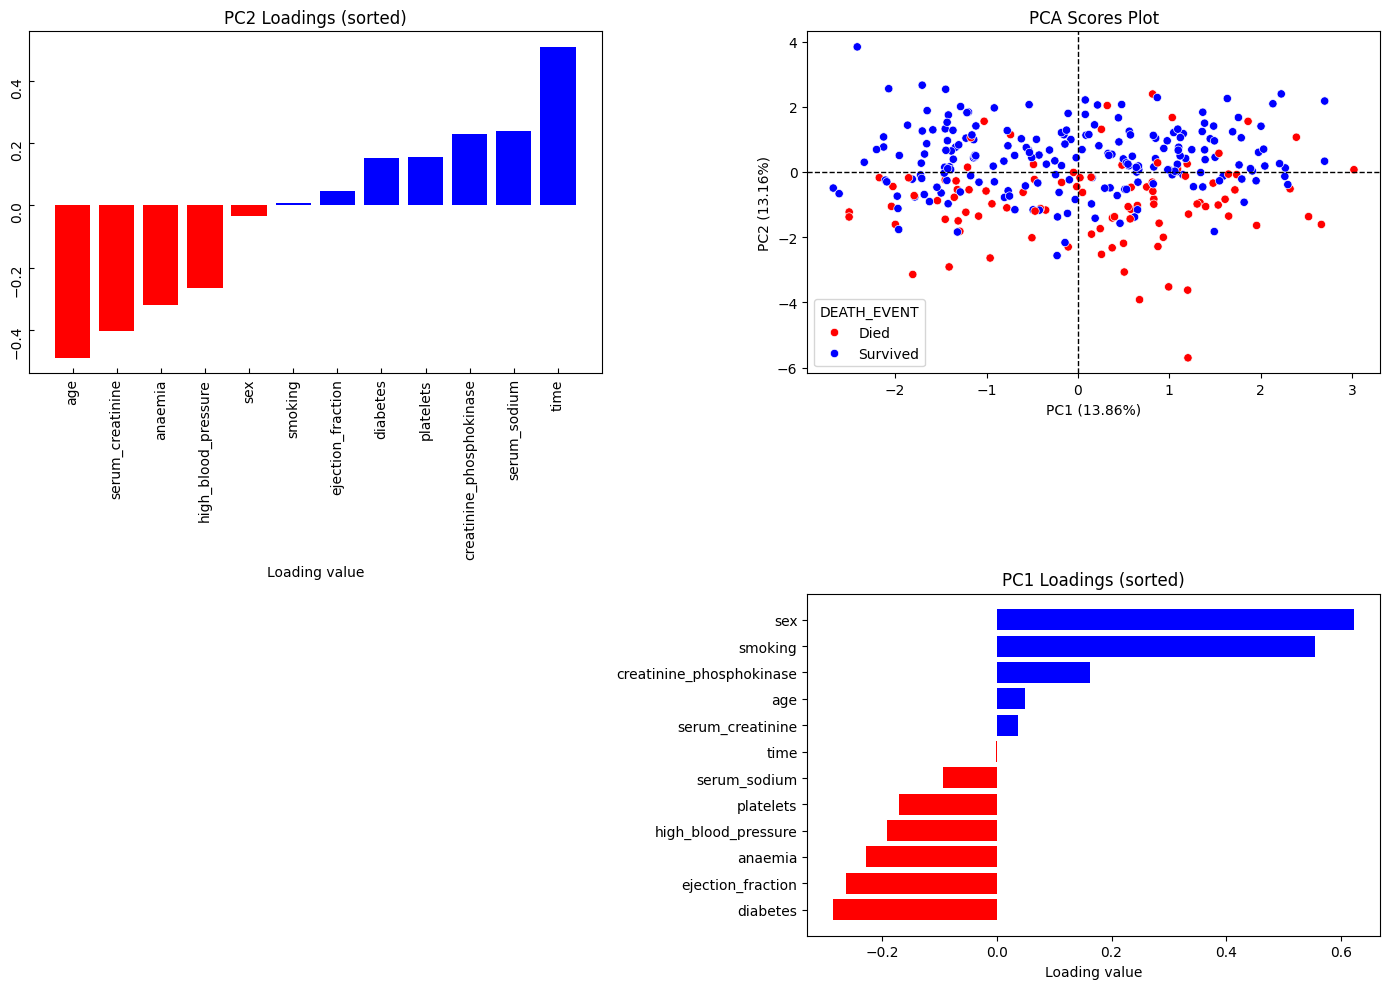

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

loadings = pca.components_.T
feature_names = df_features.columns

# Prepare loadings
pc1_loadings = pd.Series(loadings[:, 0], index=feature_names).sort_values()
pc2_loadings = pd.Series(loadings[:, 1], index=feature_names).sort_values()

pc1_colors = ['red' if v < 0 else 'blue' for v in pc1_loadings]
pc2_colors = ['red' if v < 0 else 'blue' for v in pc2_loadings]

# ---- Create subplots ----
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# (0,0) PC2 loadings
axes[0,0].bar(pc2_loadings.index, pc2_loadings.values, color=pc2_colors)
axes[0,0].set_title('PC2 Loadings (sorted)')
axes[0,0].set_xlabel('Loading value')
axes[0,0].tick_params(axis='both', direction='in',rotation=90)

# (0,1) Scores plot
color_mapping = {'Died': 'r', 'Survived': 'b'}
sns.scatterplot(x=y[:,0], y=y[:,1], hue=df_target.map({1: 'Died', 0: 'Survived'}), ax=axes[0,1], palette=color_mapping)
axes[0,1].axhline(0, linestyle='--', linewidth=1, color='black')
axes[0,1].axvline(0, linestyle='--', linewidth=1, color='black')
axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
axes[0,1].set_title('PCA Scores Plot')

# (1,1) PC1 loadings
axes[1,1].barh(pc1_loadings.index, pc1_loadings.values, color=pc1_colors)
axes[1,1].set_title('PC1 Loadings (sorted)')
axes[1,1].set_xlabel('Loading value')

# (1,0) Empty subplot
axes[1,0].axis('off')

plt.tight_layout()
plt.show()

# Exercise: Run the PCA on non normalized data. What do you see and why it happens?

In [ ]:
# write your code here




# Exercise: Run the PCA on normalized data but this time exclude the 'time' column. 

In [ ]:
# write your code here




# Cumulative Explained Variance (Scree Plot)

How many principal components do we need to capture most of the information in the data?

A common rule of thumb is to keep enough components to explain **~80-90%** of the total variance.

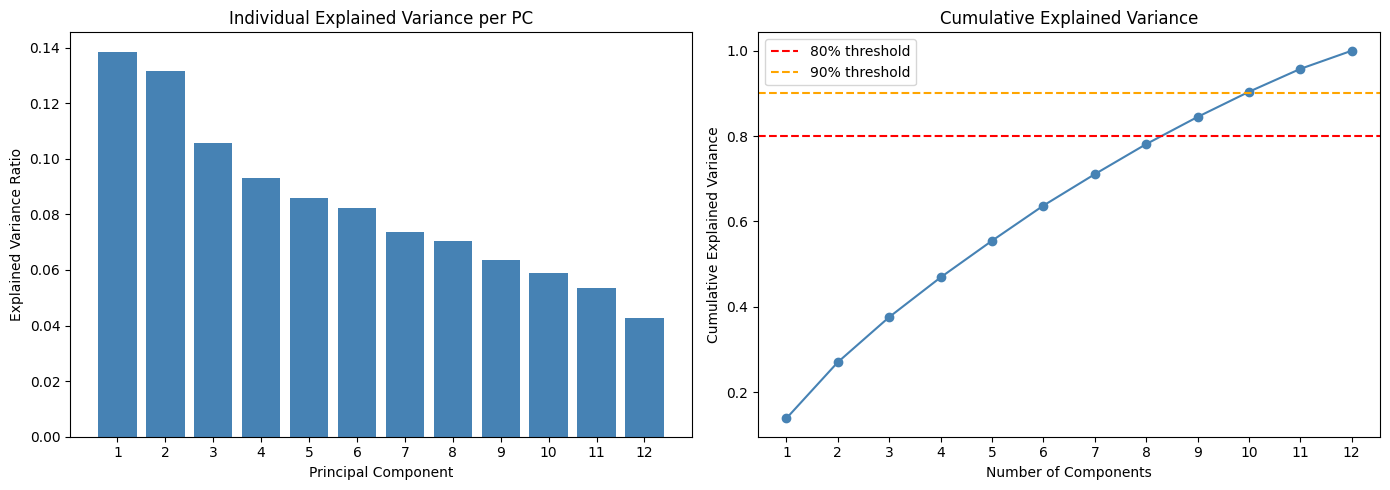

Components needed for 80% variance: 9
Components needed for 90% variance: 10


In [162]:
# Fit PCA with all components to see full variance breakdown
pca_full = PCA().fit(df_features_zscored)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual explained variance
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Individual Explained Variance per PC')
axes[0].set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))

# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', color='steelblue')
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xticks(range(1, len(cumulative_variance) + 1))
axes[1].legend()

plt.tight_layout()
plt.show()

# Print how many components needed for 80% and 90%
for threshold in [0.8, 0.9]:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Components needed for {threshold:.0%} variance: {n_components}")

# Discussion: If you run PCA on non-normalized data, PC1 explains ~90% of the variance by itself. Is this a good thing? Why or why not?

# K-Means Clustering

Now that we can visualize the data in lower dimensions with PCA, let's see if unsupervised clustering can recover the survived/died groups without using the labels.

In [189]:
# Exclude the time column for clustering (it's a follow-up period, not a clinical feature)

import numpy as np 
import pandas as pd 

df = pd.read_csv('./heart_failure_clinical_records_dataset.csv') #make sure to replace with your data directory
#df.drop(columns=['time'],inplace=True) #drop the time column which is not one of the informative features 
df_features = df.iloc[:,:-1]
df_target = df['DEATH_EVENT']
# exclude the time column in df_features
df_features = df_features.drop(columns=['time'])
#normalize the data
from scipy import stats
df_features_normalized = stats.zscore(df_features)
df_features_normalized = pd.DataFrame(df_features_normalized, columns=df_features.columns)


#KMEANS
from sklearn.cluster import KMeans

# KMeans on scaled feature space (NOT PCA)
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(df_features_normalized)
clusters
# Save labels
df_features_normalized['Cluster'] = clusters
df_features_normalized

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,Cluster
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,0
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,0
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,0
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,0
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,-0.871105,-0.537688,1.179830,-0.007077,1.359272,-1.109765e+00,-0.284552,1.447094,0.735688,1.454161,0
295,-0.491279,-0.871105,1.278215,-0.847579,-0.007077,-0.735688,6.802472e-02,-0.187726,0.539054,-1.359272,-0.687682,1
296,-1.333392,-0.871105,1.525979,1.179830,1.854958,-0.735688,4.902082e+00,-0.575031,0.312044,-1.359272,-0.687682,1
297,-1.333392,-0.871105,1.890398,-0.847579,-0.007077,-0.735688,-1.263389e+00,0.005926,0.766064,0.735688,1.454161,0


/opt/anaconda3/envs/vmb_env_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


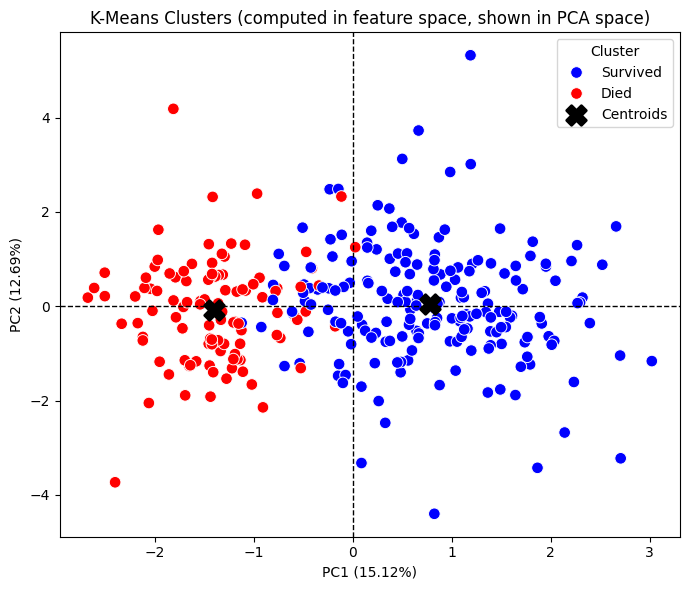

In [190]:
# Visualize K-Means clusters in PCA space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
#PCA
pca = PCA(n_components=3)
pca = pca.fit(df_features_normalized.iloc[:,:-1])
y= pca.fit_transform(df_features_normalized.iloc[:,:-1])

plt.figure(figsize=(7,6))

color_mapping = {'Died': 'r', 'Survived': 'b'}
sns.scatterplot(
    x=y[:,0],
    y=y[:,1],
    hue=df_features_normalized['Cluster'].map({1: 'Died', 0: 'Survived'}), palette=color_mapping,
    s=70
)

# Transform cluster centers into PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)

plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=200, linewidth=2, color='black', label='Centroids')

plt.axhline(0, linestyle='--', linewidth=1, color='black')
plt.axvline(0, linestyle='--', linewidth=1, color='black')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('K-Means Clusters (computed in feature space, shown in PCA space)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

[Text(0, 0.5, 'Survived'), Text(0, 1.5, 'Died')]

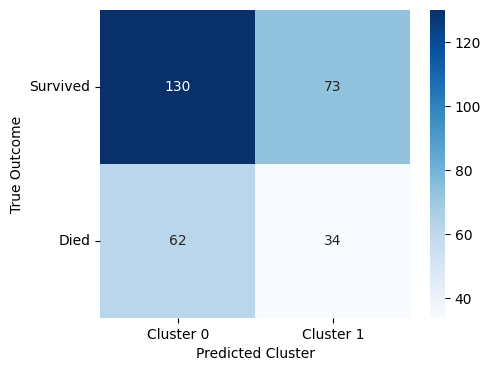

In [191]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_target, clusters)
import seaborn as sns
#sns.heatmap(cm,annot=True)

plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

ax.set_xlabel('Predicted Cluster')
ax.set_ylabel('True Outcome')
ax.set_xticklabels(['Cluster 0', 'Cluster 1'])
ax.set_yticklabels(['Survived', 'Died'], rotation=0)


# How to identify the optimal number of K?

Silhouette score = $\frac{b-a}{max(a,b)}$

For each datapoint: 

a: distance to points in the same cluster

b: distance to points in other clusters

silhouette score = 1 --> perfect clustering

silhouette score < 0.25 --> weak clustering 



In [192]:
df_features_normalized

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,Cluster
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,0
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,0
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,0
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,0
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,-0.871105,-0.537688,1.179830,-0.007077,1.359272,-1.109765e+00,-0.284552,1.447094,0.735688,1.454161,0
295,-0.491279,-0.871105,1.278215,-0.847579,-0.007077,-0.735688,6.802472e-02,-0.187726,0.539054,-1.359272,-0.687682,1
296,-1.333392,-0.871105,1.525979,1.179830,1.854958,-0.735688,4.902082e+00,-0.575031,0.312044,-1.359272,-0.687682,1
297,-1.333392,-0.871105,1.890398,-0.847579,-0.007077,-0.735688,-1.263389e+00,0.005926,0.766064,0.735688,1.454161,0


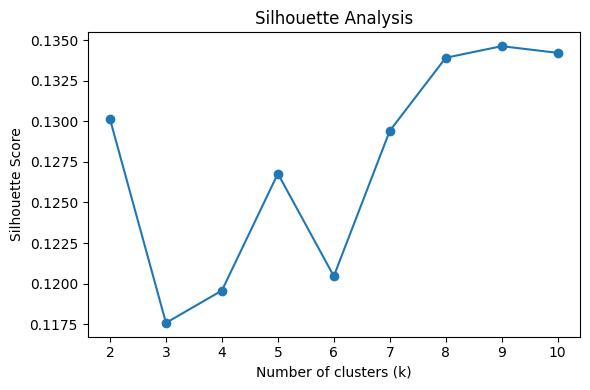

In [193]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
sil_scores = []
K = range(2, 11)   # silhouette requires at least 2 clusters

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(df_features_normalized.iloc[:,:-1])
    
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(df_features_normalized.iloc[:,:-1], labels))

plt.figure(figsize=(6,4))
plt.plot(K, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()


# Elbow Method

The **elbow method** plots the **inertia** (within-cluster sum of squares) against the number of clusters K.

$$\text{Inertia} = \sum_{i=1}^{n} \| x_i - c_{k} \|^2$$

where $c_k$ is the centroid of the cluster that point $x_i$ belongs to.

- As K increases, inertia always decreases (more clusters = points closer to centroids)
- The **elbow** is where adding more clusters gives **diminishing returns** -- the curve bends
- Pick the K at the "elbow" of the curve

In [195]:
df_features_normalized.drop(columns=['Cluster'],inplace=True)

In [196]:
df_features_normalized

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682
...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,-0.871105,-0.537688,1.179830,-0.007077,1.359272,-1.109765e+00,-0.284552,1.447094,0.735688,1.454161
295,-0.491279,-0.871105,1.278215,-0.847579,-0.007077,-0.735688,6.802472e-02,-0.187726,0.539054,-1.359272,-0.687682
296,-1.333392,-0.871105,1.525979,1.179830,1.854958,-0.735688,4.902082e+00,-0.575031,0.312044,-1.359272,-0.687682
297,-1.333392,-0.871105,1.890398,-0.847579,-0.007077,-0.735688,-1.263389e+00,0.005926,0.766064,0.735688,1.454161


In [197]:
from sklearn.metrics import silhouette_score

inertia = []
sil_scores = []
K = range(2, 11)   # silhouette requires at least 2 clusters

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(df_features_normalized)
    
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(df_features_normalized, labels))


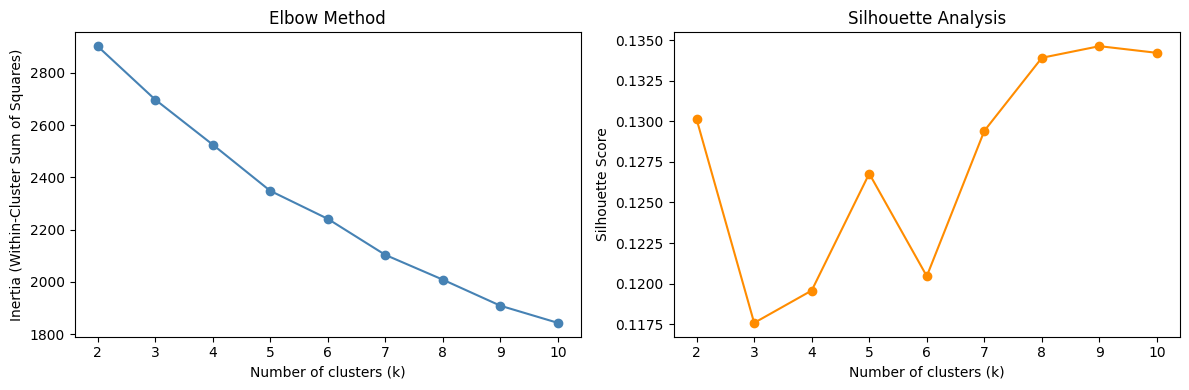

In [198]:
# Elbow plot using the inertia values already computed above
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Elbow plot
axes[0].plot(K, inertia, marker='o', color='steelblue')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)')
axes[0].set_title('Elbow Method')

# Silhouette plot (side by side for comparison)
axes[1].plot(K, sil_scores, marker='o', color='darkorange')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()

# Exercise: Run Kmeans with another K value, and plot for top 2 features identified from last week. 

## You should make a scatter plot, x-axis is one feature, y-axis is another, color them based on cluster label.

In [ ]:
# write your code here




# run k-means with k=2, make 2 subplots for top 2 features, one color them with real labels (target values), another with cluster label. 

In [ ]:
# write your code here




# Hierarchical (Agglomerative) Clustering

**Key differences from K-Means:**
- **Bottom-up** approach: starts with each point as its own cluster, then merges the closest pairs
- Does **not** require specifying K upfront -- you can decide after seeing the **dendrogram**
- Produces a **tree structure** (dendrogram) showing how clusters merge at different distance thresholds

**Linkage methods** (how to measure distance between clusters):
- `ward`: minimizes the total within-cluster variance (default, tends to produce balanced clusters)
- `complete`: maximum distance between any two points in the two clusters
- `average`: average distance between all pairs of points across the two clusters
- `single`: minimum distance between any two points (can produce elongated chains)

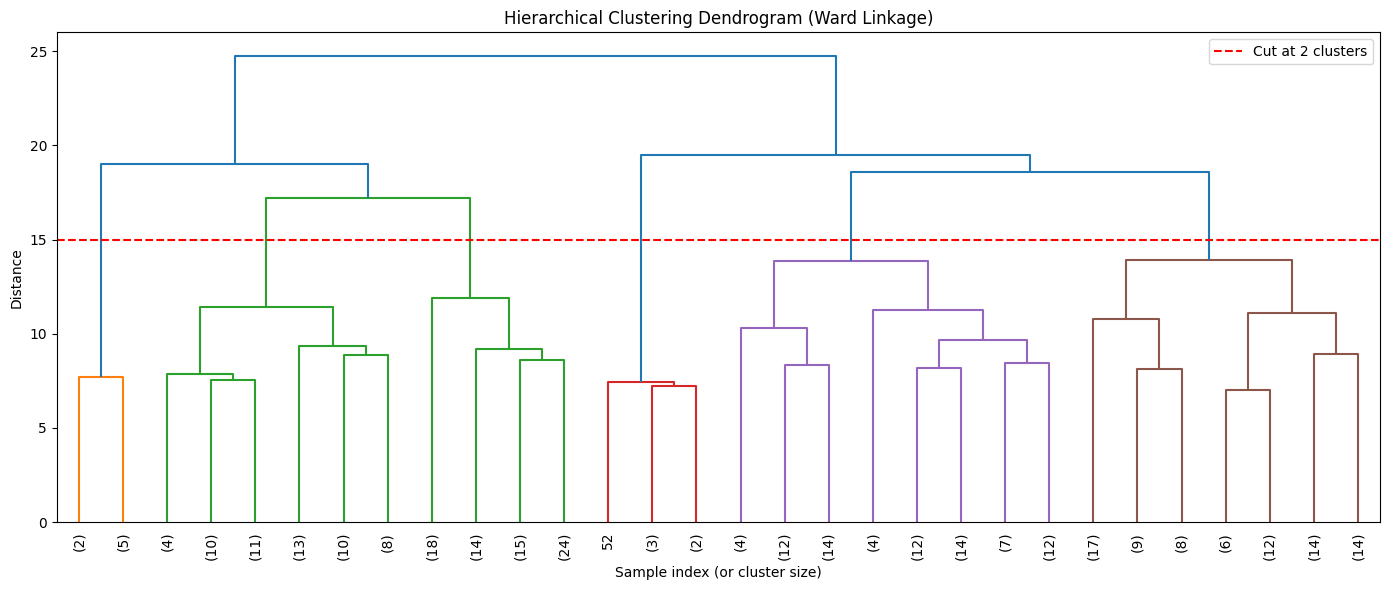

In [199]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the linkage matrix using Ward's method
Z = linkage(df_features_normalized, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample index (or cluster size)')
plt.ylabel('Distance')
plt.axhline(y=15, color='red', linestyle='--', label='Cut at 2 clusters')
plt.legend()
plt.tight_layout()
plt.show()

In [200]:
from sklearn.cluster import AgglomerativeClustering

# Cut the dendrogram at 2 clusters
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
hc_labels = agg.fit_predict(df_features_normalized)

print(f"Cluster 0: {sum(hc_labels == 0)} points")
print(f"Cluster 1: {sum(hc_labels == 1)} points")

Cluster 0: 165 points
Cluster 1: 134 points


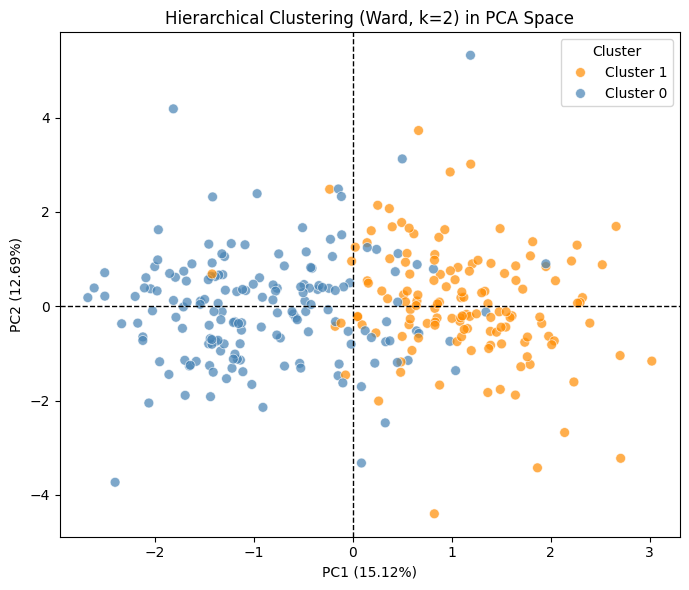

In [201]:
# Visualize hierarchical clustering in PCA space
pca_hc = PCA(n_components=2).fit(df_features_normalized)
y_hc = pca_hc.transform(df_features_normalized)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    x=y_hc[:, 0], y=y_hc[:, 1],
    hue=pd.Series(hc_labels).map({0: 'Cluster 0', 1: 'Cluster 1'}),
    palette={'Cluster 0': 'steelblue', 'Cluster 1': 'darkorange'},
    s=50, alpha=0.7
)
plt.axhline(0, linestyle='--', linewidth=1, color='black')
plt.axvline(0, linestyle='--', linewidth=1, color='black')
plt.xlabel(f'PC1 ({pca_hc.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca_hc.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Hierarchical Clustering (Ward, k=2) in PCA Space')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# K-Means vs Hierarchical Clustering Comparison

Let's visualize both clustering results side by side, along with the true labels, to see how each method groups the data.

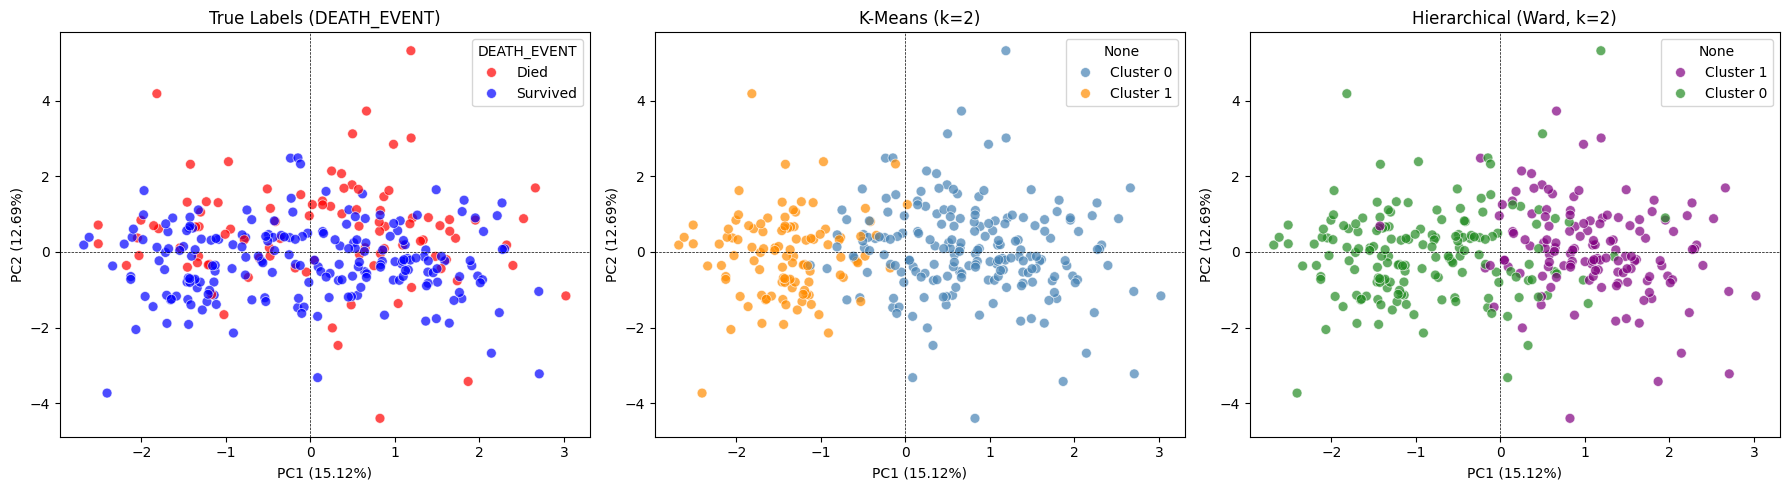

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# True labels
color_mapping = {'Died': 'r', 'Survived': 'b'}
sns.scatterplot(x=y_hc[:, 0], y=y_hc[:, 1],
                hue=df_target.map({1: 'Died', 0: 'Survived'}),
                palette=color_mapping, ax=axes[0], s=50, alpha=0.7)
axes[0].set_title('True Labels (DEATH_EVENT)')
axes[0].set_xlabel(f'PC1 ({pca_hc.explained_variance_ratio_[0]*100:.2f}%)')
axes[0].set_ylabel(f'PC2 ({pca_hc.explained_variance_ratio_[1]*100:.2f}%)')

# K-Means clusters
sns.scatterplot(x=y_hc[:, 0], y=y_hc[:, 1],
                hue=pd.Series(clusters).map({0: 'Cluster 0', 1: 'Cluster 1'}),
                palette={'Cluster 0': 'steelblue', 'Cluster 1': 'darkorange'},
                ax=axes[1], s=50, alpha=0.7, legend='full')
axes[1].set_title('K-Means (k=2)')
axes[1].set_xlabel(f'PC1 ({pca_hc.explained_variance_ratio_[0]*100:.2f}%)')
axes[1].set_ylabel(f'PC2 ({pca_hc.explained_variance_ratio_[1]*100:.2f}%)')

# Hierarchical clusters
sns.scatterplot(x=y_hc[:, 0], y=y_hc[:, 1],
                hue=pd.Series(hc_labels).map({0: 'Cluster 0', 1: 'Cluster 1'}),
                palette={'Cluster 0': 'forestgreen', 'Cluster 1': 'purple'},
                ax=axes[2], s=50, alpha=0.7, legend='full')
axes[2].set_title('Hierarchical (Ward, k=2)')
axes[2].set_xlabel(f'PC1 ({pca_hc.explained_variance_ratio_[0]*100:.2f}%)')
axes[2].set_ylabel(f'PC2 ({pca_hc.explained_variance_ratio_[1]*100:.2f}%)')

for ax in axes:
    ax.axhline(0, linestyle='--', linewidth=0.5, color='black')
    ax.axvline(0, linestyle='--', linewidth=0.5, color='black')

plt.tight_layout()
plt.show()

# Exercise: Try different linkage methods (`complete`, `average`, `single`) and compare the dendrograms. How does the tree shape change?

In [ ]:
# write your code here




# Hierarchical Clustering Confusion Matrix

# Excercise: Let's compare the confusion matrices of K-Means and Hierarchical Clustering to see which better recovers the true survived/died groups.

In [204]:
#write your code here


















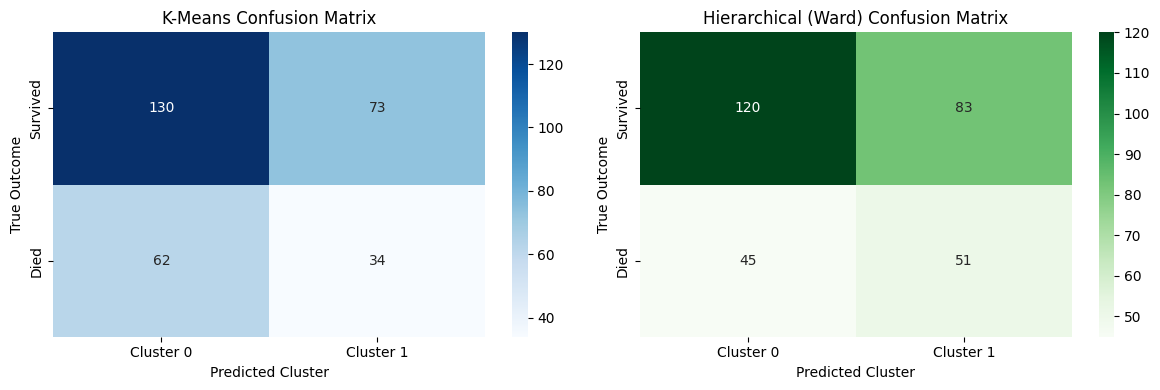

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# K-Means confusion matrix
cm_km = confusion_matrix(df_target, clusters)
sns.heatmap(cm_km, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Survived', 'Died'])
axes[0].set_xlabel('Predicted Cluster')
axes[0].set_ylabel('True Outcome')
axes[0].set_title('K-Means Confusion Matrix')

# Hierarchical confusion matrix
cm_hc = confusion_matrix(df_target, hc_labels)
sns.heatmap(cm_hc, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Survived', 'Died'])
axes[1].set_xlabel('Predicted Cluster')
axes[1].set_ylabel('True Outcome')
axes[1].set_title('Hierarchical (Ward) Confusion Matrix')

plt.tight_layout()
plt.show()

# Discussion: Why do K-Means and hierarchical clustering fail to cleanly separate the survived and died groups in this dataset?

# Practice: Run the statistical analysis we worked on in week 2 with the normalized data. is there any difference? why or why not?  

In [ ]:
# write your code here




# Discussion: Does normalizing the data change the results of a t-test or Mann-Whitney U test? Why or why not?

# Summary

**Key Takeaways from Week 3:**

1. **Data Normalization**: Z-score standardization is essential before PCA and clustering so that high-variance features (e.g., platelets, creatinine_phosphokinase) don't dominate
2. **PCA**: Reduces dimensionality while preserving variance. Cumulative explained variance plots help decide how many components to keep
3. **K-Means**: Partitions data into K spherical clusters. Requires choosing K in advance using the **elbow method** (inertia) or **silhouette scores**
4. **Hierarchical Clustering**: Bottom-up approach that produces a dendrogram. No need to pick K upfront -- cut the tree at different heights to explore different groupings. Linkage method choice affects cluster shape
5. **K-Means vs Hierarchical**: K-Means is fast but requires K upfront and is sensitive to initialization. Hierarchical is deterministic and gives a full tree of merge history, but is slower on large datasets
6. **Confusion Matrix**: Useful for comparing unsupervised clusters against known labels, even though clustering is unsupervised

**Next Steps**: Supervised learning -- using the labeled data to build predictive models

# Exercise Solutions

## Solution: PCA on non-normalized data

In [ ]:
pca_raw = PCA(n_components=3)
y_raw = pca_raw.fit_transform(df_features)

print("Explained variance ratio (non-normalized):", pca_raw.explained_variance_ratio_)
print(f"PC1 alone explains {pca_raw.explained_variance_ratio_[0]*100:.2f}% of variance\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

color_mapping = {'Died': 'r', 'Survived': 'b'}
sns.scatterplot(x=y_raw[:, 0], y=y_raw[:, 1],
                hue=df_target.map({1: 'Died', 0: 'Survived'}),
                palette=color_mapping, ax=axes[0], s=50)
axes[0].set_title('PCA on NON-normalized data')
axes[0].set_xlabel(f'PC1 ({pca_raw.explained_variance_ratio_[0]*100:.2f}%)')
axes[0].set_ylabel(f'PC2 ({pca_raw.explained_variance_ratio_[1]*100:.2f}%)')

sns.scatterplot(x=y[:, 0], y=y[:, 1],
                hue=df_target.map({1: 'Died', 0: 'Survived'}),
                palette=color_mapping, ax=axes[1], s=50)
axes[1].set_title('PCA on z-scored data')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')

plt.tight_layout()
plt.show()

loadings_raw = pd.Series(pca_raw.components_[0], index=df_features.columns).sort_values()
print("PC1 loadings (non-normalized):")
print(loadings_raw)
print("\nPlatelets dominates PC1 because its raw variance is ~9.5 billion.")
print("Without normalization, PCA just captures the feature with the largest scale.")

## Solution: PCA on normalized data excluding time

In [ ]:
df_no_time = df_features.drop(columns=['time'])
df_no_time_zscored = stats.zscore(df_no_time)

pca_no_time = PCA(n_components=3)
y_no_time = pca_no_time.fit_transform(df_no_time_zscored)

print("Explained variance ratio (no time):", pca_no_time.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

color_mapping = {'Died': 'r', 'Survived': 'b'}
sns.scatterplot(x=y[:, 0], y=y[:, 1],
                hue=df_target.map({1: 'Died', 0: 'Survived'}),
                palette=color_mapping, ax=axes[0], s=50)
axes[0].set_title('PCA with time')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')

sns.scatterplot(x=y_no_time[:, 0], y=y_no_time[:, 1],
                hue=df_target.map({1: 'Died', 0: 'Survived'}),
                palette=color_mapping, ax=axes[1], s=50)
axes[1].set_title('PCA without time')
axes[1].set_xlabel(f'PC1 ({pca_no_time.explained_variance_ratio_[0]*100:.2f}%)')
axes[1].set_ylabel(f'PC2 ({pca_no_time.explained_variance_ratio_[1]*100:.2f}%)')

plt.tight_layout()
plt.show()

loadings_no_time = pd.Series(pca_no_time.components_[0], index=df_no_time.columns).sort_values()
print("\nPC1 loadings (without time):")
print(loadings_no_time)

## Solution: K-Means with another K, scatter on top 2 features

In [ ]:
km3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters_k3 = km3.fit_predict(df_features_normalized)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_features_normalized['ejection_fraction'],
    y=df_features_normalized['serum_creatinine'],
    hue=clusters_k3,
    palette='Set1',
    s=60, alpha=0.7
)
plt.xlabel('Ejection Fraction (z-scored)')
plt.ylabel('Serum Creatinine (z-scored)')
plt.title('K-Means (k=3) on Top 2 Features')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Solution: K-Means k=2, real labels vs cluster labels side-by-side

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

color_mapping = {'Died': 'r', 'Survived': 'b'}
sns.scatterplot(
    x=df_features_normalized['ejection_fraction'],
    y=df_features_normalized['serum_creatinine'],
    hue=df_target.map({1: 'Died', 0: 'Survived'}),
    palette=color_mapping, ax=axes[0], s=60, alpha=0.7
)
axes[0].set_title('True Labels (DEATH_EVENT)')
axes[0].set_xlabel('Ejection Fraction (z-scored)')
axes[0].set_ylabel('Serum Creatinine (z-scored)')

sns.scatterplot(
    x=df_features_normalized['ejection_fraction'],
    y=df_features_normalized['serum_creatinine'],
    hue=pd.Series(clusters).map({0: 'Cluster 0', 1: 'Cluster 1'}),
    palette={'Cluster 0': 'steelblue', 'Cluster 1': 'darkorange'},
    ax=axes[1], s=60, alpha=0.7
)
axes[1].set_title('K-Means Cluster Labels (k=2)')
axes[1].set_xlabel('Ejection Fraction (z-scored)')
axes[1].set_ylabel('Serum Creatinine (z-scored)')

plt.tight_layout()
plt.show()

## Solution: Compare different linkage methods

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, method in zip(axes, ['complete', 'average', 'single']):
    Z_method = linkage(df_features_normalized, method=method)
    dendrogram(Z_method, truncate_mode='lastp', p=30,
               leaf_rotation=90, leaf_font_size=9, ax=ax)
    ax.set_title(f'{method.capitalize()} Linkage')
    ax.set_xlabel('Sample index (or cluster size)')
    ax.set_ylabel('Distance')

plt.tight_layout()
plt.show()

print("Ward: balanced, compact clusters (minimizes variance)")
print("Complete: tends to produce compact clusters, sensitive to outliers")
print("Average: compromise between single and complete")
print("Single: can produce elongated 'chaining' clusters")

## Solution: Statistical analysis on normalized data

In [ ]:
from scipy.stats import ttest_ind

survived = df_target == 0
died = df_target == 1

results_norm = []
results_raw = []

for col in df_features_normalized.columns:
    t_stat_n, p_val_n = ttest_ind(df_features_normalized.loc[survived, col],
                                   df_features_normalized.loc[died, col], equal_var=False)
    t_stat_r, p_val_r = ttest_ind(df_features_no_time.loc[survived, col],
                                   df_features_no_time.loc[died, col], equal_var=False)
    results_norm.append({'Feature': col, 'P-Value (normalized)': p_val_n})
    results_raw.append({'Feature': col, 'P-Value (raw)': p_val_r})

comparison = pd.DataFrame(results_norm)
comparison['P-Value (raw)'] = [r['P-Value (raw)'] for r in results_raw]
comparison['Difference'] = abs(comparison['P-Value (normalized)'] - comparison['P-Value (raw)'])
comparison = comparison.sort_values('P-Value (normalized)')

print(comparison.to_string(index=False))
print("\nThe p-values are IDENTICAL. Z-scoring is a linear transformation")
print("(subtract mean, divide by std). It does not change the t-statistic")
print("because both numerator and denominator scale by the same factor.")

# Resources

**Data Normalization:**
- [Scikit-learn Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Z-score vs Min-Max Scaling](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)

**PCA:**
- [Scikit-learn PCA Documentation](https://scikit-learn.org/stable/modules/decomposition.html#pca)
- [StatQuest: PCA Explained](https://www.youtube.com/watch?v=FgakZw6K1QQ)

**K-Means:**
- [Scikit-learn KMeans](https://scikit-learn.org/stable/modules/clustering.html#k-means)
- [Elbow Method Explained](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)
- [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

**Hierarchical Clustering:**
- [Scikit-learn Agglomerative Clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)
- [Scipy Dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)
- [StatQuest: Hierarchical Clustering](https://www.youtube.com/watch?v=7xHsRkOdVwo)

**Confusion Matrix:**
- [Scikit-learn Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)